In [1]:
import mdtraj as md
from ase import Atoms
import nglview as nv
import networkx as nx
import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGPooling, InnerProductDecoder
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# loading the xtc and gro file into mdtraj
traj = md.load('../../../xtc_files/50000eql2.xtc', top='../../../xtc_files/conf.gro')

In [3]:
# converting traj as traj with only 5000 frames
traj=traj[::10]

In [4]:
# creating the frame feature matrix
nframes = traj.xyz.shape[0]
natoms=traj.topology.residue(0).n_atoms
nmols=traj.topology.n_residues
frame_feature=[]
for i in tqdm(range(nframes)):
    com_pos=[] # position of Center of Mass of each molecule
    for res in range(nmols):
        com_pos.append(traj.xyz[i][res*natoms:(res+1)*natoms].mean(axis=0))
    frame_feature.append(com_pos)
frame_feature=np.array(frame_feature)
print(frame_feature.shape)

100%|██████████| 5001/5001 [00:28<00:00, 172.95it/s]


(5001, 592, 3)


In [5]:
# creating the edge index matrix
cutoff=0.5
all_edge_list=[]
for i in tqdm(range(nframes)):
    fromlist=[]
    tolist=[]
    for j in range(nmols):
        for k in range(j+1,nmols):
            if np.linalg.norm(frame_feature[i][j]-frame_feature[i][k])<cutoff:
                fromlist.append(j)
                tolist.append(k)
                tolist.append(j)
                fromlist.append(k)
    edgelist=np.array([fromlist,tolist]).astype(np.int64)
    all_edge_list.append(edgelist)
print(len(all_edge_list))

100%|██████████| 5001/5001 [45:12<00:00,  1.84it/s]  

5001


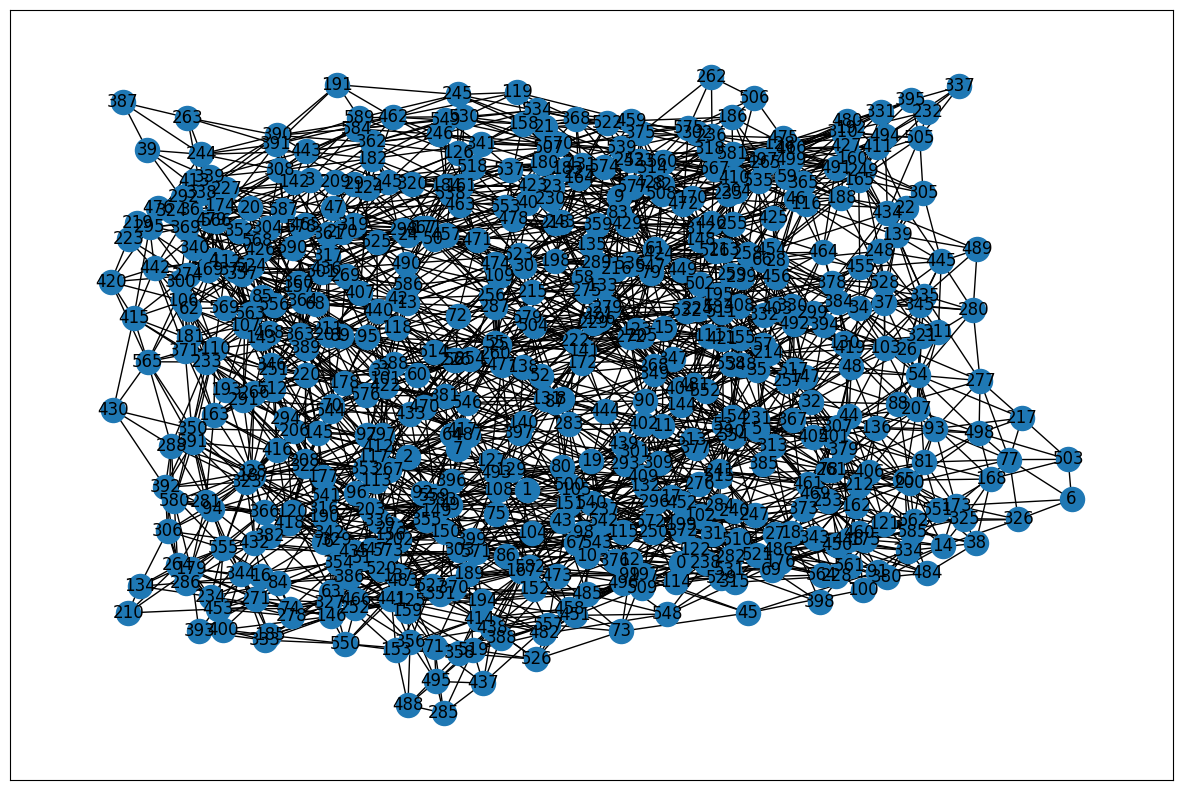

In [6]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index
frame = 10
plt.figure(figsize=(15,10))
adj_binary = convert_to_adj(all_edge_list[frame], num_nodes=592)
indices = torch.where(adj_binary)
G = nx.Graph()
edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
G.add_edges_from(edges)
nx.draw_networkx(G)

In [7]:
graphs = []
for frame in tqdm(range(nframes)):
    g = data.Data(x=torch.tensor(frame_feature[frame]).float(), edge_index=torch.tensor(all_edge_list[frame]).long(), y=torch.tensor([0]))
    graphs.append(g)

print(graphs[0])

100%|██████████| 5001/5001 [00:00<00:00, 19688.52it/s]

Data(x=[592, 3], edge_index=[2, 8126], y=[1])


In [8]:
# import model.
from model import *

In [9]:
input_dim = graphs[0].num_features
output_dim = 2
lr=1e-4
epochs=100
batch_size=1
model=VGAE(VariationalGCNEncoder(input_dim, output_dim),
           VariationalGCNDecoder(output_dim,input_dim))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
from pytorch3d.loss import chamfer_distance

In [11]:
train_loader_set = DataLoader(graphs[:int(nframes*0.6)], batch_size=batch_size, shuffle=True)
validation_loader_set = DataLoader(graphs[int(nframes*0.6):int(nframes*0.8)], batch_size=batch_size, shuffle=True)
test_loader_set = DataLoader(graphs[int(nframes*0.8):], batch_size=batch_size, shuffle=True)

In [12]:
#for data in train_loader_set:
#    z,encoded_edgeindex=model.encode(data.x,data.edge_index)
#    decodedx,decoded_edgeindex=model.decode(z,encoded_edgeindex)
#    # print(data)
#    print(decodedx)
#    print("data.x")
#    print(data.x)
#    print("sizes")
#    print(decodedx.size())
#    print(data.x.size())

In [13]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in train_loader_set:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss 
        loss = FeatureLoss + EdgeLoss + closs
        loss = loss 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

        loss.backward()
        optimizer.step()

        

    return loss_all / len(train_loader_set.dataset),closs_all/len(train_loader_set.dataset), feature_loss_all / len(train_loader_set.dataset), edge_loss_all / len(train_loader_set.dataset), kl_loss_all / len(train_loader_set.dataset)

In [14]:
# writing a vakidation function
def validate():
    model.eval()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    closs_all=0
    for data in validation_loader_set:
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        # loss = FeatureLoss + EdgeLoss 
        loss = FeatureLoss + EdgeLoss + closs
        loss = loss 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

    return loss_all / len(validation_loader_set.dataset),closs_all/len(validation_loader_set.dataset), feature_loss_all / len(validation_loader_set.dataset), edge_loss_all / len(validation_loader_set.dataset), kl_loss_all / len(validation_loader_set.dataset)

In [15]:
lossFxn = torch.nn.MSELoss()
def test():
    model.eval()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0
    type_loss_all = 0
    closs_all=0
    for data in test_loader_set:
        optimizer.zero_grad()
        z,encoded_edge_index = model.encode(data.x, data.edge_index)
        decoded_x, decoded_edge_index= model.decode(z, encoded_edge_index)
        out2=decoded_x.reshape(1,592,3)
        in2=data.x.reshape(1,592,3)
        closs=chamfer_distance(out2,in2)
        # print(closs[0])
        closs=closs[0]
        closs=torch.tensor(closs, dtype=torch.float32)
        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        loss = FeatureLoss + EdgeLoss+closs 
        closs_all+=float(closs)
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        

    return loss_all / len(test_loader_set.dataset), closs_all/len(test_loader_set.dataset),feature_loss_all / len(test_loader_set.dataset), edge_loss_all / len(test_loader_set.dataset), kl_loss_all / len(test_loader_set.dataset)

In [16]:
total_losses = []
feature_losses = []
edge_losses = []
kl_losses = []
val_total_losses = []
val_feature_losses = []
val_edge_losses = []
val_kl_losses = []
test_total_losses = []
test_feature_losses = []
test_edge_losses = []
test_kl_losses = []
cd_losses=[]
val_cd_losses=[]
test_cd_losses=[]
for epoch in tqdm(range(1, epochs+ 1)):
    total_loss, cd_loss,feature_loss, edge_loss, kl_loss = train()
    val_total_loss, val_cd_loss,val_feature_loss, val_edge_loss, val_kl_loss = validate()
    test_total_loss, test_cd_loss,test_feature_loss, test_edge_loss, test_kl_loss = test()
    print(f'Epoch: {epoch:03d}')
    print(f'TRAIN : Total Loss: {total_loss:.4f}, CD Loss : {cd_loss:.4f}, Feature Loss: {feature_loss:.4f}, Edge Loss: {edge_loss:.4f}')
    print(f'VALIDATE : Total Loss: {val_total_loss:.4f}, CD Loss : {val_cd_loss:.4f},Feature Loss: {val_feature_loss:.4f}, Edge Loss: {val_edge_loss:.4f}')
    print(f'TEST : Total Loss: {test_total_loss:.4f},CD Loss : {test_cd_loss:.4f}, Feature Loss: {test_feature_loss:.4f}, Edge Loss: {test_edge_loss:.4f}')
    total_losses.append(total_loss)
    feature_losses.append(feature_loss)
    edge_losses.append(edge_loss)
    kl_losses.append(kl_loss)
    val_total_losses.append(val_total_loss)
    val_feature_losses.append(val_feature_loss)
    val_edge_losses.append(val_edge_loss)
    val_kl_losses.append(val_kl_loss)
    test_total_losses.append(test_total_loss)
    test_feature_losses.append(test_feature_loss)
    test_edge_losses.append(test_edge_loss)
    test_kl_losses.append(test_kl_loss)
    cd_losses.append(cd_loss)
    val_cd_losses.append(val_cd_loss)   
    test_cd_losses.append(test_cd_loss) 
    

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_3297/1287167025.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
/tmp/ipykernel_3297/368484634.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
/tmp/ipykernel_3297/3817500453.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  closs=torch.tensor(closs, dtype=torch.float32)
  1%|          | 1/100 [00:35<58:41, 35.57s/it]

Epoch: 001
TRAIN : Total Loss: 5.0049, CD Loss : 3.5083, Feature Loss: 1.4967, Edge Loss: 0.0000
VALIDATE : Total Loss: 2.1640, CD Loss : 1.4950,Feature Loss: 0.6689, Edge Loss: 0.0000
TEST : Total Loss: 2.1627,CD Loss : 1.4940, Feature Loss: 0.6687, Edge Loss: 0.0000


  2%|▏         | 2/100 [01:20<1:07:08, 41.11s/it]

Epoch: 002
TRAIN : Total Loss: 1.2837, CD Loss : 0.8013, Feature Loss: 0.4824, Edge Loss: 0.0000
VALIDATE : Total Loss: 1.0785, CD Loss : 0.7136,Feature Loss: 0.3649, Edge Loss: 0.0000
TEST : Total Loss: 1.0785,CD Loss : 0.7139, Feature Loss: 0.3646, Edge Loss: 0.0000


  3%|▎         | 3/100 [01:58<1:03:53, 39.52s/it]

Epoch: 003
TRAIN : Total Loss: 0.9391, CD Loss : 0.6337, Feature Loss: 0.3054, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.8369, CD Loss : 0.6050,Feature Loss: 0.2319, Edge Loss: 0.0000
TEST : Total Loss: 0.8371,CD Loss : 0.6054, Feature Loss: 0.2317, Edge Loss: 0.0000


  4%|▍         | 4/100 [02:33<1:00:45, 37.98s/it]

Epoch: 004
TRAIN : Total Loss: 0.8392, CD Loss : 0.6023, Feature Loss: 0.2369, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.8217, CD Loss : 0.5984,Feature Loss: 0.2233, Edge Loss: 0.0000
TEST : Total Loss: 0.8219,CD Loss : 0.5987, Feature Loss: 0.2232, Edge Loss: 0.0000


  5%|▌         | 5/100 [03:20<1:04:53, 40.98s/it]

Epoch: 005
TRAIN : Total Loss: 0.8223, CD Loss : 0.5976, Feature Loss: 0.2247, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.8125, CD Loss : 0.5944,Feature Loss: 0.2181, Edge Loss: 0.0000
TEST : Total Loss: 0.8126,CD Loss : 0.5947, Feature Loss: 0.2179, Edge Loss: 0.0000


  6%|▌         | 6/100 [04:07<1:07:50, 43.30s/it]

Epoch: 006
TRAIN : Total Loss: 0.8076, CD Loss : 0.5906, Feature Loss: 0.2170, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.7955, CD Loss : 0.5834,Feature Loss: 0.2120, Edge Loss: 0.0000
TEST : Total Loss: 0.7955,CD Loss : 0.5836, Feature Loss: 0.2119, Edge Loss: 0.0000


  7%|▋         | 7/100 [04:48<1:05:29, 42.26s/it]

Epoch: 007
TRAIN : Total Loss: 0.7755, CD Loss : 0.5682, Feature Loss: 0.2073, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.7325, CD Loss : 0.5346,Feature Loss: 0.1979, Edge Loss: 0.0000
TEST : Total Loss: 0.7324,CD Loss : 0.5347, Feature Loss: 0.1977, Edge Loss: 0.0000


  8%|▊         | 8/100 [05:35<1:07:32, 44.05s/it]

Epoch: 008
TRAIN : Total Loss: 0.6256, CD Loss : 0.4435, Feature Loss: 0.1821, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.5419, CD Loss : 0.3733,Feature Loss: 0.1686, Edge Loss: 0.0000
TEST : Total Loss: 0.5417,CD Loss : 0.3733, Feature Loss: 0.1684, Edge Loss: 0.0000


  9%|▉         | 9/100 [06:10<1:02:20, 41.11s/it]

Epoch: 009
TRAIN : Total Loss: 0.5065, CD Loss : 0.3447, Feature Loss: 0.1617, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.4764, CD Loss : 0.3211,Feature Loss: 0.1553, Edge Loss: 0.0000
TEST : Total Loss: 0.4765,CD Loss : 0.3213, Feature Loss: 0.1552, Edge Loss: 0.0000


 10%|█         | 10/100 [06:54<1:02:50, 41.90s/it]

Epoch: 010
TRAIN : Total Loss: 0.4440, CD Loss : 0.2952, Feature Loss: 0.1488, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.4120, CD Loss : 0.2694,Feature Loss: 0.1426, Edge Loss: 0.0000
TEST : Total Loss: 0.4122,CD Loss : 0.2698, Feature Loss: 0.1424, Edge Loss: 0.0000


 11%|█         | 11/100 [07:32<1:00:17, 40.65s/it]

Epoch: 011
TRAIN : Total Loss: 0.3890, CD Loss : 0.2507, Feature Loss: 0.1383, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3688, CD Loss : 0.2342,Feature Loss: 0.1347, Edge Loss: 0.0000
TEST : Total Loss: 0.3690,CD Loss : 0.2345, Feature Loss: 0.1344, Edge Loss: 0.0000


 12%|█▏        | 12/100 [08:18<1:02:05, 42.33s/it]

Epoch: 012
TRAIN : Total Loss: 0.3500, CD Loss : 0.2190, Feature Loss: 0.1310, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3319, CD Loss : 0.2044,Feature Loss: 0.1275, Edge Loss: 0.0000
TEST : Total Loss: 0.3319,CD Loss : 0.2046, Feature Loss: 0.1273, Edge Loss: 0.0000


 13%|█▎        | 13/100 [09:06<1:04:05, 44.20s/it]

Epoch: 013
TRAIN : Total Loss: 0.3176, CD Loss : 0.1930, Feature Loss: 0.1246, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.3052, CD Loss : 0.1831,Feature Loss: 0.1222, Edge Loss: 0.0000
TEST : Total Loss: 0.3051,CD Loss : 0.1832, Feature Loss: 0.1220, Edge Loss: 0.0000


 14%|█▍        | 14/100 [09:50<1:03:20, 44.19s/it]

Epoch: 014
TRAIN : Total Loss: 0.2974, CD Loss : 0.1775, Feature Loss: 0.1199, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2912, CD Loss : 0.1732,Feature Loss: 0.1180, Edge Loss: 0.0000
TEST : Total Loss: 0.2911,CD Loss : 0.1732, Feature Loss: 0.1178, Edge Loss: 0.0000


 15%|█▌        | 15/100 [10:24<58:13, 41.10s/it]  

Epoch: 015
TRAIN : Total Loss: 0.2859, CD Loss : 0.1701, Feature Loss: 0.1159, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2812, CD Loss : 0.1672,Feature Loss: 0.1140, Edge Loss: 0.0000
TEST : Total Loss: 0.2811,CD Loss : 0.1672, Feature Loss: 0.1139, Edge Loss: 0.0000


 16%|█▌        | 16/100 [11:02<56:07, 40.09s/it]

Epoch: 016
TRAIN : Total Loss: 0.2774, CD Loss : 0.1654, Feature Loss: 0.1120, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2735, CD Loss : 0.1633,Feature Loss: 0.1102, Edge Loss: 0.0000
TEST : Total Loss: 0.2735,CD Loss : 0.1634, Feature Loss: 0.1101, Edge Loss: 0.0000


 17%|█▋        | 17/100 [11:36<52:45, 38.14s/it]

Epoch: 017
TRAIN : Total Loss: 0.2695, CD Loss : 0.1612, Feature Loss: 0.1083, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2654, CD Loss : 0.1589,Feature Loss: 0.1065, Edge Loss: 0.0000
TEST : Total Loss: 0.2655,CD Loss : 0.1591, Feature Loss: 0.1064, Edge Loss: 0.0000


 18%|█▊        | 18/100 [12:12<51:20, 37.56s/it]

Epoch: 018
TRAIN : Total Loss: 0.2621, CD Loss : 0.1573, Feature Loss: 0.1048, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2589, CD Loss : 0.1556,Feature Loss: 0.1032, Edge Loss: 0.0000
TEST : Total Loss: 0.2590,CD Loss : 0.1558, Feature Loss: 0.1032, Edge Loss: 0.0000


 19%|█▉        | 19/100 [13:02<56:00, 41.49s/it]

Epoch: 019
TRAIN : Total Loss: 0.2559, CD Loss : 0.1540, Feature Loss: 0.1019, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2535, CD Loss : 0.1529,Feature Loss: 0.1005, Edge Loss: 0.0000
TEST : Total Loss: 0.2537,CD Loss : 0.1531, Feature Loss: 0.1006, Edge Loss: 0.0000


 20%|██        | 20/100 [13:48<56:59, 42.75s/it]

Epoch: 020
TRAIN : Total Loss: 0.2507, CD Loss : 0.1512, Feature Loss: 0.0994, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2484, CD Loss : 0.1501,Feature Loss: 0.0983, Edge Loss: 0.0000
TEST : Total Loss: 0.2486,CD Loss : 0.1503, Feature Loss: 0.0984, Edge Loss: 0.0000


 21%|██        | 21/100 [14:38<59:08, 44.92s/it]

Epoch: 021
TRAIN : Total Loss: 0.2463, CD Loss : 0.1489, Feature Loss: 0.0974, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2444, CD Loss : 0.1479,Feature Loss: 0.0965, Edge Loss: 0.0000
TEST : Total Loss: 0.2446,CD Loss : 0.1481, Feature Loss: 0.0965, Edge Loss: 0.0000


 22%|██▏       | 22/100 [15:13<54:18, 41.77s/it]

Epoch: 022
TRAIN : Total Loss: 0.2424, CD Loss : 0.1467, Feature Loss: 0.0957, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2406, CD Loss : 0.1458,Feature Loss: 0.0949, Edge Loss: 0.0000
TEST : Total Loss: 0.2409,CD Loss : 0.1460, Feature Loss: 0.0949, Edge Loss: 0.0000


 23%|██▎       | 23/100 [15:54<53:30, 41.69s/it]

Epoch: 023
TRAIN : Total Loss: 0.2390, CD Loss : 0.1449, Feature Loss: 0.0942, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2373, CD Loss : 0.1439,Feature Loss: 0.0934, Edge Loss: 0.0000
TEST : Total Loss: 0.2376,CD Loss : 0.1441, Feature Loss: 0.0935, Edge Loss: 0.0000


 24%|██▍       | 24/100 [16:40<54:21, 42.91s/it]

Epoch: 024
TRAIN : Total Loss: 0.2358, CD Loss : 0.1430, Feature Loss: 0.0928, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2345, CD Loss : 0.1423,Feature Loss: 0.0922, Edge Loss: 0.0000
TEST : Total Loss: 0.2347,CD Loss : 0.1425, Feature Loss: 0.0921, Edge Loss: 0.0000


 25%|██▌       | 25/100 [17:21<52:48, 42.24s/it]

Epoch: 025
TRAIN : Total Loss: 0.2329, CD Loss : 0.1414, Feature Loss: 0.0915, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2312, CD Loss : 0.1402,Feature Loss: 0.0910, Edge Loss: 0.0000
TEST : Total Loss: 0.2313,CD Loss : 0.1404, Feature Loss: 0.0910, Edge Loss: 0.0000


 26%|██▌       | 26/100 [17:58<50:27, 40.92s/it]

Epoch: 026
TRAIN : Total Loss: 0.2303, CD Loss : 0.1398, Feature Loss: 0.0904, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2293, CD Loss : 0.1393,Feature Loss: 0.0900, Edge Loss: 0.0000
TEST : Total Loss: 0.2293,CD Loss : 0.1395, Feature Loss: 0.0899, Edge Loss: 0.0000


 27%|██▋       | 27/100 [18:43<51:15, 42.13s/it]

Epoch: 027
TRAIN : Total Loss: 0.2281, CD Loss : 0.1386, Feature Loss: 0.0894, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2272, CD Loss : 0.1381,Feature Loss: 0.0891, Edge Loss: 0.0000
TEST : Total Loss: 0.2272,CD Loss : 0.1382, Feature Loss: 0.0890, Edge Loss: 0.0000


 28%|██▊       | 28/100 [19:20<48:41, 40.57s/it]

Epoch: 028
TRAIN : Total Loss: 0.2263, CD Loss : 0.1377, Feature Loss: 0.0886, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2255, CD Loss : 0.1371,Feature Loss: 0.0883, Edge Loss: 0.0000
TEST : Total Loss: 0.2254,CD Loss : 0.1372, Feature Loss: 0.0882, Edge Loss: 0.0000


 29%|██▉       | 29/100 [20:06<49:59, 42.25s/it]

Epoch: 029
TRAIN : Total Loss: 0.2248, CD Loss : 0.1368, Feature Loss: 0.0879, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2237, CD Loss : 0.1359,Feature Loss: 0.0877, Edge Loss: 0.0000
TEST : Total Loss: 0.2236,CD Loss : 0.1360, Feature Loss: 0.0876, Edge Loss: 0.0000


 30%|███       | 30/100 [20:55<51:27, 44.10s/it]

Epoch: 030
TRAIN : Total Loss: 0.2235, CD Loss : 0.1361, Feature Loss: 0.0874, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2234, CD Loss : 0.1362,Feature Loss: 0.0873, Edge Loss: 0.0000
TEST : Total Loss: 0.2233,CD Loss : 0.1362, Feature Loss: 0.0871, Edge Loss: 0.0000


 31%|███       | 31/100 [21:38<50:22, 43.80s/it]

Epoch: 031
TRAIN : Total Loss: 0.2225, CD Loss : 0.1356, Feature Loss: 0.0869, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2216, CD Loss : 0.1349,Feature Loss: 0.0868, Edge Loss: 0.0000
TEST : Total Loss: 0.2215,CD Loss : 0.1349, Feature Loss: 0.0866, Edge Loss: 0.0000


 32%|███▏      | 32/100 [22:20<49:03, 43.29s/it]

Epoch: 032
TRAIN : Total Loss: 0.2216, CD Loss : 0.1352, Feature Loss: 0.0864, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2211, CD Loss : 0.1347,Feature Loss: 0.0864, Edge Loss: 0.0000
TEST : Total Loss: 0.2209,CD Loss : 0.1348, Feature Loss: 0.0862, Edge Loss: 0.0000


 33%|███▎      | 33/100 [22:59<46:59, 42.09s/it]

Epoch: 033
TRAIN : Total Loss: 0.2209, CD Loss : 0.1348, Feature Loss: 0.0861, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2204, CD Loss : 0.1344,Feature Loss: 0.0860, Edge Loss: 0.0000
TEST : Total Loss: 0.2203,CD Loss : 0.1345, Feature Loss: 0.0858, Edge Loss: 0.0000


 34%|███▍      | 34/100 [23:44<47:11, 42.90s/it]

Epoch: 034
TRAIN : Total Loss: 0.2201, CD Loss : 0.1344, Feature Loss: 0.0857, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2196, CD Loss : 0.1339,Feature Loss: 0.0857, Edge Loss: 0.0000
TEST : Total Loss: 0.2195,CD Loss : 0.1340, Feature Loss: 0.0855, Edge Loss: 0.0000


 35%|███▌      | 35/100 [24:31<47:47, 44.11s/it]

Epoch: 035
TRAIN : Total Loss: 0.2195, CD Loss : 0.1341, Feature Loss: 0.0854, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2194, CD Loss : 0.1340,Feature Loss: 0.0854, Edge Loss: 0.0000
TEST : Total Loss: 0.2193,CD Loss : 0.1341, Feature Loss: 0.0852, Edge Loss: 0.0000


 36%|███▌      | 36/100 [25:13<46:12, 43.32s/it]

Epoch: 036
TRAIN : Total Loss: 0.2190, CD Loss : 0.1339, Feature Loss: 0.0851, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2187, CD Loss : 0.1336,Feature Loss: 0.0851, Edge Loss: 0.0000
TEST : Total Loss: 0.2185,CD Loss : 0.1336, Feature Loss: 0.0849, Edge Loss: 0.0000


 37%|███▋      | 37/100 [25:55<45:07, 42.98s/it]

Epoch: 037
TRAIN : Total Loss: 0.2185, CD Loss : 0.1336, Feature Loss: 0.0848, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2184, CD Loss : 0.1336,Feature Loss: 0.0848, Edge Loss: 0.0000
TEST : Total Loss: 0.2182,CD Loss : 0.1336, Feature Loss: 0.0846, Edge Loss: 0.0000


 38%|███▊      | 38/100 [26:33<42:57, 41.57s/it]

Epoch: 038
TRAIN : Total Loss: 0.2180, CD Loss : 0.1334, Feature Loss: 0.0846, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2178, CD Loss : 0.1332,Feature Loss: 0.0846, Edge Loss: 0.0000
TEST : Total Loss: 0.2176,CD Loss : 0.1332, Feature Loss: 0.0844, Edge Loss: 0.0000


 39%|███▉      | 39/100 [27:15<42:26, 41.75s/it]

Epoch: 039
TRAIN : Total Loss: 0.2176, CD Loss : 0.1332, Feature Loss: 0.0843, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2172, CD Loss : 0.1328,Feature Loss: 0.0843, Edge Loss: 0.0000
TEST : Total Loss: 0.2170,CD Loss : 0.1329, Feature Loss: 0.0841, Edge Loss: 0.0000


 40%|████      | 40/100 [27:52<40:09, 40.15s/it]

Epoch: 040
TRAIN : Total Loss: 0.2171, CD Loss : 0.1330, Feature Loss: 0.0841, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2169, CD Loss : 0.1328,Feature Loss: 0.0841, Edge Loss: 0.0000
TEST : Total Loss: 0.2167,CD Loss : 0.1328, Feature Loss: 0.0839, Edge Loss: 0.0000


 41%|████      | 41/100 [28:29<38:32, 39.20s/it]

Epoch: 041
TRAIN : Total Loss: 0.2167, CD Loss : 0.1328, Feature Loss: 0.0839, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2168, CD Loss : 0.1329,Feature Loss: 0.0839, Edge Loss: 0.0000
TEST : Total Loss: 0.2166,CD Loss : 0.1329, Feature Loss: 0.0837, Edge Loss: 0.0000


 42%|████▏     | 42/100 [29:08<38:02, 39.36s/it]

Epoch: 042
TRAIN : Total Loss: 0.2164, CD Loss : 0.1328, Feature Loss: 0.0836, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2161, CD Loss : 0.1325,Feature Loss: 0.0836, Edge Loss: 0.0000
TEST : Total Loss: 0.2159,CD Loss : 0.1325, Feature Loss: 0.0834, Edge Loss: 0.0000


 43%|████▎     | 43/100 [29:48<37:22, 39.35s/it]

Epoch: 043
TRAIN : Total Loss: 0.2159, CD Loss : 0.1325, Feature Loss: 0.0834, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2156, CD Loss : 0.1322,Feature Loss: 0.0834, Edge Loss: 0.0000
TEST : Total Loss: 0.2155,CD Loss : 0.1323, Feature Loss: 0.0832, Edge Loss: 0.0000


 44%|████▍     | 44/100 [30:28<36:52, 39.51s/it]

Epoch: 044
TRAIN : Total Loss: 0.2157, CD Loss : 0.1325, Feature Loss: 0.0832, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2153, CD Loss : 0.1321,Feature Loss: 0.0832, Edge Loss: 0.0000
TEST : Total Loss: 0.2152,CD Loss : 0.1322, Feature Loss: 0.0830, Edge Loss: 0.0000


 45%|████▌     | 45/100 [31:17<38:56, 42.49s/it]

Epoch: 045
TRAIN : Total Loss: 0.2152, CD Loss : 0.1322, Feature Loss: 0.0830, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2153, CD Loss : 0.1323,Feature Loss: 0.0830, Edge Loss: 0.0000
TEST : Total Loss: 0.2151,CD Loss : 0.1323, Feature Loss: 0.0828, Edge Loss: 0.0000


 46%|████▌     | 46/100 [31:58<37:47, 42.00s/it]

Epoch: 046
TRAIN : Total Loss: 0.2149, CD Loss : 0.1321, Feature Loss: 0.0828, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2147, CD Loss : 0.1319,Feature Loss: 0.0828, Edge Loss: 0.0000
TEST : Total Loss: 0.2145,CD Loss : 0.1319, Feature Loss: 0.0826, Edge Loss: 0.0000


 47%|████▋     | 47/100 [32:42<37:36, 42.57s/it]

Epoch: 047
TRAIN : Total Loss: 0.2147, CD Loss : 0.1321, Feature Loss: 0.0826, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2144, CD Loss : 0.1318,Feature Loss: 0.0826, Edge Loss: 0.0000
TEST : Total Loss: 0.2142,CD Loss : 0.1318, Feature Loss: 0.0824, Edge Loss: 0.0000


 48%|████▊     | 48/100 [33:23<36:28, 42.09s/it]

Epoch: 048
TRAIN : Total Loss: 0.2143, CD Loss : 0.1319, Feature Loss: 0.0824, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2137, CD Loss : 0.1313,Feature Loss: 0.0824, Edge Loss: 0.0000
TEST : Total Loss: 0.2135,CD Loss : 0.1313, Feature Loss: 0.0822, Edge Loss: 0.0000


 49%|████▉     | 49/100 [34:04<35:39, 41.95s/it]

Epoch: 049
TRAIN : Total Loss: 0.2141, CD Loss : 0.1318, Feature Loss: 0.0823, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2138, CD Loss : 0.1316,Feature Loss: 0.0823, Edge Loss: 0.0000
TEST : Total Loss: 0.2137,CD Loss : 0.1316, Feature Loss: 0.0821, Edge Loss: 0.0000


 50%|█████     | 50/100 [34:44<34:28, 41.36s/it]

Epoch: 050
TRAIN : Total Loss: 0.2138, CD Loss : 0.1317, Feature Loss: 0.0821, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2135, CD Loss : 0.1314,Feature Loss: 0.0821, Edge Loss: 0.0000
TEST : Total Loss: 0.2134,CD Loss : 0.1315, Feature Loss: 0.0819, Edge Loss: 0.0000


 51%|█████     | 51/100 [35:18<31:52, 39.03s/it]

Epoch: 051
TRAIN : Total Loss: 0.2136, CD Loss : 0.1317, Feature Loss: 0.0820, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2136, CD Loss : 0.1316,Feature Loss: 0.0820, Edge Loss: 0.0000
TEST : Total Loss: 0.2134,CD Loss : 0.1317, Feature Loss: 0.0818, Edge Loss: 0.0000


 52%|█████▏    | 52/100 [35:53<30:17, 37.86s/it]

Epoch: 052
TRAIN : Total Loss: 0.2133, CD Loss : 0.1314, Feature Loss: 0.0818, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2129, CD Loss : 0.1311,Feature Loss: 0.0818, Edge Loss: 0.0000
TEST : Total Loss: 0.2128,CD Loss : 0.1312, Feature Loss: 0.0816, Edge Loss: 0.0000


 53%|█████▎    | 53/100 [36:41<31:55, 40.75s/it]

Epoch: 053
TRAIN : Total Loss: 0.2131, CD Loss : 0.1314, Feature Loss: 0.0817, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2131, CD Loss : 0.1314,Feature Loss: 0.0817, Edge Loss: 0.0000
TEST : Total Loss: 0.2130,CD Loss : 0.1315, Feature Loss: 0.0815, Edge Loss: 0.0000


 54%|█████▍    | 54/100 [37:18<30:23, 39.64s/it]

Epoch: 054
TRAIN : Total Loss: 0.2129, CD Loss : 0.1313, Feature Loss: 0.0816, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2128, CD Loss : 0.1312,Feature Loss: 0.0816, Edge Loss: 0.0000
TEST : Total Loss: 0.2127,CD Loss : 0.1313, Feature Loss: 0.0814, Edge Loss: 0.0000


 55%|█████▌    | 55/100 [38:01<30:33, 40.75s/it]

Epoch: 055
TRAIN : Total Loss: 0.2127, CD Loss : 0.1312, Feature Loss: 0.0815, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2129, CD Loss : 0.1314,Feature Loss: 0.0815, Edge Loss: 0.0000
TEST : Total Loss: 0.2128,CD Loss : 0.1315, Feature Loss: 0.0813, Edge Loss: 0.0000


 56%|█████▌    | 56/100 [38:35<28:22, 38.70s/it]

Epoch: 056
TRAIN : Total Loss: 0.2125, CD Loss : 0.1311, Feature Loss: 0.0814, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2127, CD Loss : 0.1313,Feature Loss: 0.0814, Edge Loss: 0.0000
TEST : Total Loss: 0.2125,CD Loss : 0.1314, Feature Loss: 0.0812, Edge Loss: 0.0000


 57%|█████▋    | 57/100 [39:11<27:12, 37.96s/it]

Epoch: 057
TRAIN : Total Loss: 0.2123, CD Loss : 0.1311, Feature Loss: 0.0812, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2124, CD Loss : 0.1311,Feature Loss: 0.0813, Edge Loss: 0.0000
TEST : Total Loss: 0.2122,CD Loss : 0.1311, Feature Loss: 0.0811, Edge Loss: 0.0000


 58%|█████▊    | 58/100 [39:48<26:15, 37.51s/it]

Epoch: 058
TRAIN : Total Loss: 0.2121, CD Loss : 0.1310, Feature Loss: 0.0811, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2120, CD Loss : 0.1308,Feature Loss: 0.0812, Edge Loss: 0.0000
TEST : Total Loss: 0.2119,CD Loss : 0.1309, Feature Loss: 0.0810, Edge Loss: 0.0000


 59%|█████▉    | 59/100 [40:27<26:04, 38.15s/it]

Epoch: 059
TRAIN : Total Loss: 0.2119, CD Loss : 0.1309, Feature Loss: 0.0810, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2122, CD Loss : 0.1311,Feature Loss: 0.0811, Edge Loss: 0.0000
TEST : Total Loss: 0.2120,CD Loss : 0.1312, Feature Loss: 0.0809, Edge Loss: 0.0000


 60%|██████    | 60/100 [41:04<25:12, 37.80s/it]

Epoch: 060
TRAIN : Total Loss: 0.2118, CD Loss : 0.1308, Feature Loss: 0.0810, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2119, CD Loss : 0.1309,Feature Loss: 0.0810, Edge Loss: 0.0000
TEST : Total Loss: 0.2118,CD Loss : 0.1309, Feature Loss: 0.0808, Edge Loss: 0.0000


 61%|██████    | 61/100 [41:41<24:24, 37.55s/it]

Epoch: 061
TRAIN : Total Loss: 0.2116, CD Loss : 0.1307, Feature Loss: 0.0809, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2114, CD Loss : 0.1305,Feature Loss: 0.0809, Edge Loss: 0.0000
TEST : Total Loss: 0.2113,CD Loss : 0.1306, Feature Loss: 0.0807, Edge Loss: 0.0000


 62%|██████▏   | 62/100 [42:22<24:30, 38.70s/it]

Epoch: 062
TRAIN : Total Loss: 0.2114, CD Loss : 0.1306, Feature Loss: 0.0808, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2117, CD Loss : 0.1308,Feature Loss: 0.0809, Edge Loss: 0.0000
TEST : Total Loss: 0.2115,CD Loss : 0.1308, Feature Loss: 0.0807, Edge Loss: 0.0000


 63%|██████▎   | 63/100 [43:05<24:30, 39.74s/it]

Epoch: 063
TRAIN : Total Loss: 0.2112, CD Loss : 0.1305, Feature Loss: 0.0807, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2112, CD Loss : 0.1305,Feature Loss: 0.0807, Edge Loss: 0.0000
TEST : Total Loss: 0.2111,CD Loss : 0.1306, Feature Loss: 0.0805, Edge Loss: 0.0000


 64%|██████▍   | 64/100 [43:46<24:08, 40.22s/it]

Epoch: 064
TRAIN : Total Loss: 0.2110, CD Loss : 0.1305, Feature Loss: 0.0806, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2109, CD Loss : 0.1302,Feature Loss: 0.0807, Edge Loss: 0.0000
TEST : Total Loss: 0.2107,CD Loss : 0.1303, Feature Loss: 0.0804, Edge Loss: 0.0000


 65%|██████▌   | 65/100 [44:26<23:22, 40.06s/it]

Epoch: 065
TRAIN : Total Loss: 0.2109, CD Loss : 0.1304, Feature Loss: 0.0805, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2112, CD Loss : 0.1306,Feature Loss: 0.0806, Edge Loss: 0.0000
TEST : Total Loss: 0.2110,CD Loss : 0.1307, Feature Loss: 0.0803, Edge Loss: 0.0000


 66%|██████▌   | 66/100 [45:04<22:27, 39.65s/it]

Epoch: 066
TRAIN : Total Loss: 0.2107, CD Loss : 0.1303, Feature Loss: 0.0804, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2106, CD Loss : 0.1302,Feature Loss: 0.0805, Edge Loss: 0.0000
TEST : Total Loss: 0.2105,CD Loss : 0.1302, Feature Loss: 0.0803, Edge Loss: 0.0000


 67%|██████▋   | 67/100 [45:47<22:16, 40.51s/it]

Epoch: 067
TRAIN : Total Loss: 0.2105, CD Loss : 0.1301, Feature Loss: 0.0803, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2101, CD Loss : 0.1297,Feature Loss: 0.0804, Edge Loss: 0.0000
TEST : Total Loss: 0.2099,CD Loss : 0.1297, Feature Loss: 0.0802, Edge Loss: 0.0000


 68%|██████▊   | 68/100 [46:24<21:00, 39.40s/it]

Epoch: 068
TRAIN : Total Loss: 0.2103, CD Loss : 0.1301, Feature Loss: 0.0802, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2106, CD Loss : 0.1302,Feature Loss: 0.0803, Edge Loss: 0.0000
TEST : Total Loss: 0.2104,CD Loss : 0.1303, Feature Loss: 0.0801, Edge Loss: 0.0000


 69%|██████▉   | 69/100 [46:58<19:32, 37.81s/it]

Epoch: 069
TRAIN : Total Loss: 0.2101, CD Loss : 0.1300, Feature Loss: 0.0801, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2101, CD Loss : 0.1299,Feature Loss: 0.0802, Edge Loss: 0.0000
TEST : Total Loss: 0.2100,CD Loss : 0.1300, Feature Loss: 0.0800, Edge Loss: 0.0000


 70%|███████   | 70/100 [47:41<19:44, 39.50s/it]

Epoch: 070
TRAIN : Total Loss: 0.2099, CD Loss : 0.1299, Feature Loss: 0.0800, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2099, CD Loss : 0.1298,Feature Loss: 0.0802, Edge Loss: 0.0000
TEST : Total Loss: 0.2098,CD Loss : 0.1298, Feature Loss: 0.0799, Edge Loss: 0.0000


 71%|███████   | 71/100 [48:27<19:55, 41.24s/it]

Epoch: 071
TRAIN : Total Loss: 0.2097, CD Loss : 0.1298, Feature Loss: 0.0800, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2095, CD Loss : 0.1294,Feature Loss: 0.0801, Edge Loss: 0.0000
TEST : Total Loss: 0.2093,CD Loss : 0.1295, Feature Loss: 0.0798, Edge Loss: 0.0000


 72%|███████▏  | 72/100 [49:03<18:35, 39.83s/it]

Epoch: 072
TRAIN : Total Loss: 0.2095, CD Loss : 0.1297, Feature Loss: 0.0799, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2094, CD Loss : 0.1293,Feature Loss: 0.0800, Edge Loss: 0.0000
TEST : Total Loss: 0.2091,CD Loss : 0.1294, Feature Loss: 0.0798, Edge Loss: 0.0000


 73%|███████▎  | 73/100 [49:50<18:54, 42.02s/it]

Epoch: 073
TRAIN : Total Loss: 0.2093, CD Loss : 0.1295, Feature Loss: 0.0798, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2089, CD Loss : 0.1290,Feature Loss: 0.0799, Edge Loss: 0.0000
TEST : Total Loss: 0.2087,CD Loss : 0.1291, Feature Loss: 0.0796, Edge Loss: 0.0000


 74%|███████▍  | 74/100 [50:33<18:16, 42.18s/it]

Epoch: 074
TRAIN : Total Loss: 0.2091, CD Loss : 0.1294, Feature Loss: 0.0797, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2093, CD Loss : 0.1295,Feature Loss: 0.0798, Edge Loss: 0.0000
TEST : Total Loss: 0.2091,CD Loss : 0.1295, Feature Loss: 0.0796, Edge Loss: 0.0000


 75%|███████▌  | 75/100 [51:12<17:14, 41.40s/it]

Epoch: 075
TRAIN : Total Loss: 0.2089, CD Loss : 0.1293, Feature Loss: 0.0796, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2090, CD Loss : 0.1293,Feature Loss: 0.0797, Edge Loss: 0.0000
TEST : Total Loss: 0.2088,CD Loss : 0.1293, Feature Loss: 0.0795, Edge Loss: 0.0000


 76%|███████▌  | 76/100 [51:54<16:33, 41.41s/it]

Epoch: 076
TRAIN : Total Loss: 0.2087, CD Loss : 0.1292, Feature Loss: 0.0795, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2087, CD Loss : 0.1291,Feature Loss: 0.0796, Edge Loss: 0.0000
TEST : Total Loss: 0.2085,CD Loss : 0.1291, Feature Loss: 0.0794, Edge Loss: 0.0000


 77%|███████▋  | 77/100 [52:39<16:22, 42.70s/it]

Epoch: 077
TRAIN : Total Loss: 0.2084, CD Loss : 0.1290, Feature Loss: 0.0794, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2087, CD Loss : 0.1292,Feature Loss: 0.0795, Edge Loss: 0.0000
TEST : Total Loss: 0.2085,CD Loss : 0.1293, Feature Loss: 0.0793, Edge Loss: 0.0000


 78%|███████▊  | 78/100 [53:18<15:14, 41.57s/it]

Epoch: 078
TRAIN : Total Loss: 0.2081, CD Loss : 0.1289, Feature Loss: 0.0793, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2086, CD Loss : 0.1292,Feature Loss: 0.0794, Edge Loss: 0.0000
TEST : Total Loss: 0.2085,CD Loss : 0.1293, Feature Loss: 0.0792, Edge Loss: 0.0000


 79%|███████▉  | 79/100 [54:05<15:02, 42.98s/it]

Epoch: 079
TRAIN : Total Loss: 0.2079, CD Loss : 0.1288, Feature Loss: 0.0792, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2079, CD Loss : 0.1286,Feature Loss: 0.0794, Edge Loss: 0.0000
TEST : Total Loss: 0.2077,CD Loss : 0.1286, Feature Loss: 0.0791, Edge Loss: 0.0000


 80%|████████  | 80/100 [54:53<14:49, 44.49s/it]

Epoch: 080
TRAIN : Total Loss: 0.2077, CD Loss : 0.1286, Feature Loss: 0.0791, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2079, CD Loss : 0.1287,Feature Loss: 0.0792, Edge Loss: 0.0000
TEST : Total Loss: 0.2078,CD Loss : 0.1288, Feature Loss: 0.0790, Edge Loss: 0.0000


 81%|████████  | 81/100 [55:32<13:35, 42.90s/it]

Epoch: 081
TRAIN : Total Loss: 0.2075, CD Loss : 0.1285, Feature Loss: 0.0790, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2075, CD Loss : 0.1284,Feature Loss: 0.0791, Edge Loss: 0.0000
TEST : Total Loss: 0.2073,CD Loss : 0.1284, Feature Loss: 0.0789, Edge Loss: 0.0000


 82%|████████▏ | 82/100 [56:11<12:33, 41.86s/it]

Epoch: 082
TRAIN : Total Loss: 0.2072, CD Loss : 0.1283, Feature Loss: 0.0789, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2075, CD Loss : 0.1285,Feature Loss: 0.0791, Edge Loss: 0.0000
TEST : Total Loss: 0.2074,CD Loss : 0.1285, Feature Loss: 0.0788, Edge Loss: 0.0000


 83%|████████▎ | 83/100 [56:51<11:40, 41.22s/it]

Epoch: 083
TRAIN : Total Loss: 0.2070, CD Loss : 0.1282, Feature Loss: 0.0788, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2071, CD Loss : 0.1281,Feature Loss: 0.0790, Edge Loss: 0.0000
TEST : Total Loss: 0.2069,CD Loss : 0.1282, Feature Loss: 0.0787, Edge Loss: 0.0000


 84%|████████▍ | 84/100 [57:25<10:22, 38.90s/it]

Epoch: 084
TRAIN : Total Loss: 0.2068, CD Loss : 0.1281, Feature Loss: 0.0787, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2069, CD Loss : 0.1280,Feature Loss: 0.0789, Edge Loss: 0.0000
TEST : Total Loss: 0.2067,CD Loss : 0.1281, Feature Loss: 0.0786, Edge Loss: 0.0000


 85%|████████▌ | 85/100 [58:00<09:29, 37.96s/it]

Epoch: 085
TRAIN : Total Loss: 0.2065, CD Loss : 0.1279, Feature Loss: 0.0786, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2065, CD Loss : 0.1277,Feature Loss: 0.0788, Edge Loss: 0.0000
TEST : Total Loss: 0.2063,CD Loss : 0.1278, Feature Loss: 0.0785, Edge Loss: 0.0000


 86%|████████▌ | 86/100 [58:41<09:02, 38.78s/it]

Epoch: 086
TRAIN : Total Loss: 0.2063, CD Loss : 0.1278, Feature Loss: 0.0785, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2061, CD Loss : 0.1274,Feature Loss: 0.0787, Edge Loss: 0.0000
TEST : Total Loss: 0.2059,CD Loss : 0.1275, Feature Loss: 0.0785, Edge Loss: 0.0000


 87%|████████▋ | 87/100 [59:19<08:22, 38.65s/it]

Epoch: 087
TRAIN : Total Loss: 0.2061, CD Loss : 0.1277, Feature Loss: 0.0784, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2062, CD Loss : 0.1276,Feature Loss: 0.0787, Edge Loss: 0.0000
TEST : Total Loss: 0.2061,CD Loss : 0.1277, Feature Loss: 0.0784, Edge Loss: 0.0000


 88%|████████▊ | 88/100 [59:53<07:26, 37.19s/it]

Epoch: 088
TRAIN : Total Loss: 0.2059, CD Loss : 0.1275, Feature Loss: 0.0783, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2063, CD Loss : 0.1277,Feature Loss: 0.0786, Edge Loss: 0.0000
TEST : Total Loss: 0.2061,CD Loss : 0.1278, Feature Loss: 0.0783, Edge Loss: 0.0000


 89%|████████▉ | 89/100 [1:00:39<07:16, 39.71s/it]

Epoch: 089
TRAIN : Total Loss: 0.2057, CD Loss : 0.1274, Feature Loss: 0.0783, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2057, CD Loss : 0.1272,Feature Loss: 0.0785, Edge Loss: 0.0000
TEST : Total Loss: 0.2055,CD Loss : 0.1273, Feature Loss: 0.0782, Edge Loss: 0.0000


 90%|█████████ | 90/100 [1:01:17<06:31, 39.20s/it]

Epoch: 090
TRAIN : Total Loss: 0.2055, CD Loss : 0.1273, Feature Loss: 0.0782, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2056, CD Loss : 0.1272,Feature Loss: 0.0784, Edge Loss: 0.0000
TEST : Total Loss: 0.2054,CD Loss : 0.1273, Feature Loss: 0.0781, Edge Loss: 0.0000


 91%|█████████ | 91/100 [1:01:54<05:47, 38.66s/it]

Epoch: 091
TRAIN : Total Loss: 0.2053, CD Loss : 0.1272, Feature Loss: 0.0781, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2054, CD Loss : 0.1271,Feature Loss: 0.0783, Edge Loss: 0.0000
TEST : Total Loss: 0.2052,CD Loss : 0.1272, Feature Loss: 0.0781, Edge Loss: 0.0000


 92%|█████████▏| 92/100 [1:02:41<05:28, 41.04s/it]

Epoch: 092
TRAIN : Total Loss: 0.2051, CD Loss : 0.1271, Feature Loss: 0.0780, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2051, CD Loss : 0.1269,Feature Loss: 0.0782, Edge Loss: 0.0000
TEST : Total Loss: 0.2050,CD Loss : 0.1270, Feature Loss: 0.0780, Edge Loss: 0.0000


 93%|█████████▎| 93/100 [1:03:17<04:37, 39.66s/it]

Epoch: 093
TRAIN : Total Loss: 0.2050, CD Loss : 0.1270, Feature Loss: 0.0780, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2052, CD Loss : 0.1270,Feature Loss: 0.0782, Edge Loss: 0.0000
TEST : Total Loss: 0.2050,CD Loss : 0.1271, Feature Loss: 0.0780, Edge Loss: 0.0000


 94%|█████████▍| 94/100 [1:03:59<04:01, 40.24s/it]

Epoch: 094
TRAIN : Total Loss: 0.2048, CD Loss : 0.1270, Feature Loss: 0.0779, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2046, CD Loss : 0.1264,Feature Loss: 0.0781, Edge Loss: 0.0000
TEST : Total Loss: 0.2044,CD Loss : 0.1265, Feature Loss: 0.0779, Edge Loss: 0.0000


 95%|█████████▌| 95/100 [1:04:43<03:26, 41.40s/it]

Epoch: 095
TRAIN : Total Loss: 0.2047, CD Loss : 0.1268, Feature Loss: 0.0778, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2049, CD Loss : 0.1268,Feature Loss: 0.0781, Edge Loss: 0.0000
TEST : Total Loss: 0.2047,CD Loss : 0.1269, Feature Loss: 0.0778, Edge Loss: 0.0000


 96%|█████████▌| 96/100 [1:05:25<02:46, 41.51s/it]

Epoch: 096
TRAIN : Total Loss: 0.2046, CD Loss : 0.1268, Feature Loss: 0.0778, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2046, CD Loss : 0.1266,Feature Loss: 0.0780, Edge Loss: 0.0000
TEST : Total Loss: 0.2045,CD Loss : 0.1267, Feature Loss: 0.0777, Edge Loss: 0.0000


 97%|█████████▋| 97/100 [1:06:06<02:04, 41.51s/it]

Epoch: 097
TRAIN : Total Loss: 0.2044, CD Loss : 0.1267, Feature Loss: 0.0777, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2045, CD Loss : 0.1265,Feature Loss: 0.0780, Edge Loss: 0.0000
TEST : Total Loss: 0.2043,CD Loss : 0.1266, Feature Loss: 0.0777, Edge Loss: 0.0000


 98%|█████████▊| 98/100 [1:06:46<01:21, 40.92s/it]

Epoch: 098
TRAIN : Total Loss: 0.2043, CD Loss : 0.1266, Feature Loss: 0.0776, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2047, CD Loss : 0.1268,Feature Loss: 0.0779, Edge Loss: 0.0000
TEST : Total Loss: 0.2045,CD Loss : 0.1269, Feature Loss: 0.0777, Edge Loss: 0.0000


 99%|█████████▉| 99/100 [1:07:24<00:40, 40.05s/it]

Epoch: 099
TRAIN : Total Loss: 0.2042, CD Loss : 0.1266, Feature Loss: 0.0776, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2051, CD Loss : 0.1272,Feature Loss: 0.0779, Edge Loss: 0.0000
TEST : Total Loss: 0.2050,CD Loss : 0.1273, Feature Loss: 0.0776, Edge Loss: 0.0000


100%|██████████| 100/100 [1:08:01<00:00, 40.82s/it]

Epoch: 100
TRAIN : Total Loss: 0.2041, CD Loss : 0.1265, Feature Loss: 0.0775, Edge Loss: 0.0000
VALIDATE : Total Loss: 0.2050, CD Loss : 0.1270,Feature Loss: 0.0779, Edge Loss: 0.0000
TEST : Total Loss: 0.2049,CD Loss : 0.1272, Feature Loss: 0.0777, Edge Loss: 0.0000


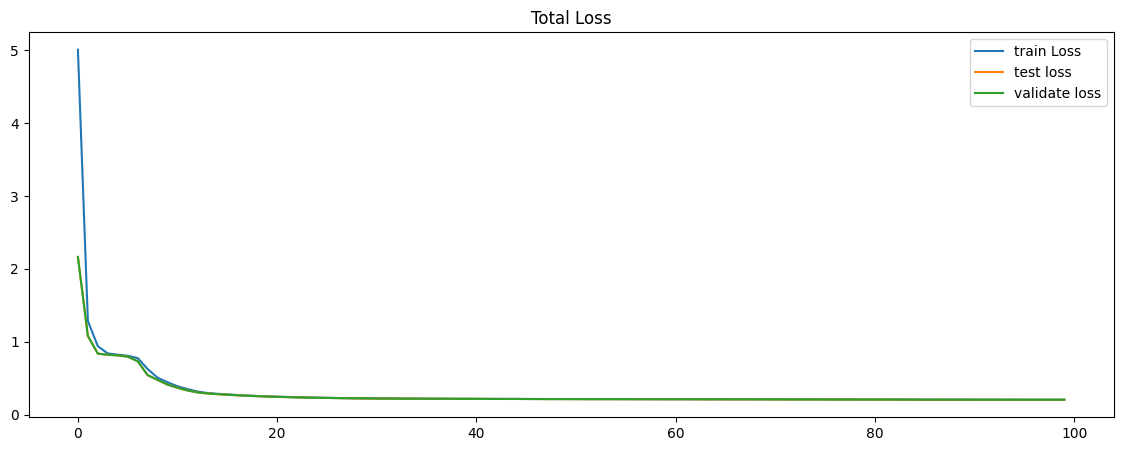

In [17]:
plt.figure(figsize=(14, 5))
plt.plot(total_losses, label='train Loss')
plt.plot(test_total_losses, label='test loss')
plt.plot(val_total_losses, label='validate loss')
plt.legend()
plt.title('Total Loss')
plt.show()

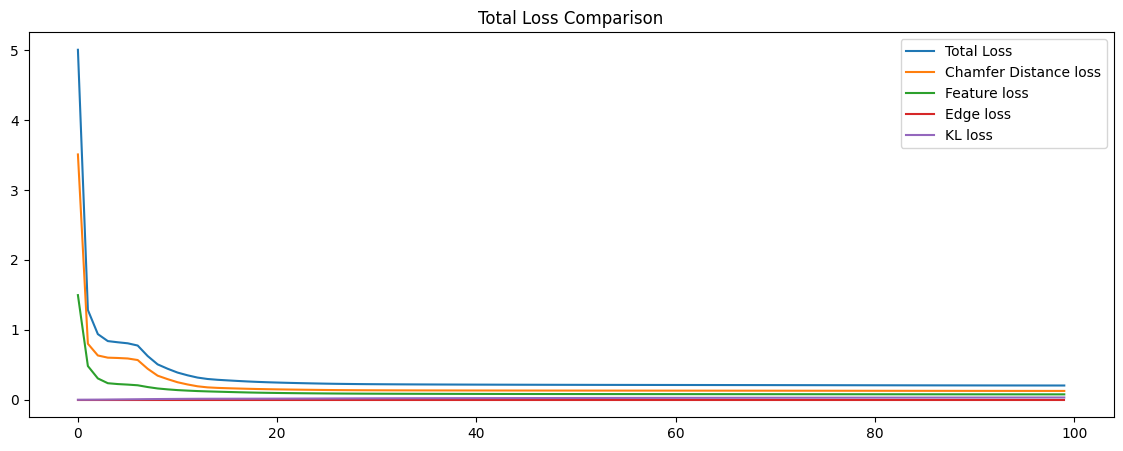

In [18]:
plt.figure(figsize=(14, 5))
plt.plot(total_losses, label='Total Loss')
plt.plot(cd_losses, label='Chamfer Distance loss')
plt.plot(feature_losses, label='Feature loss')
plt.plot(edge_losses, label='Edge loss')
plt.plot(kl_losses, label='KL loss')
plt.legend()
plt.title('Total Loss Comparison')
plt.show()

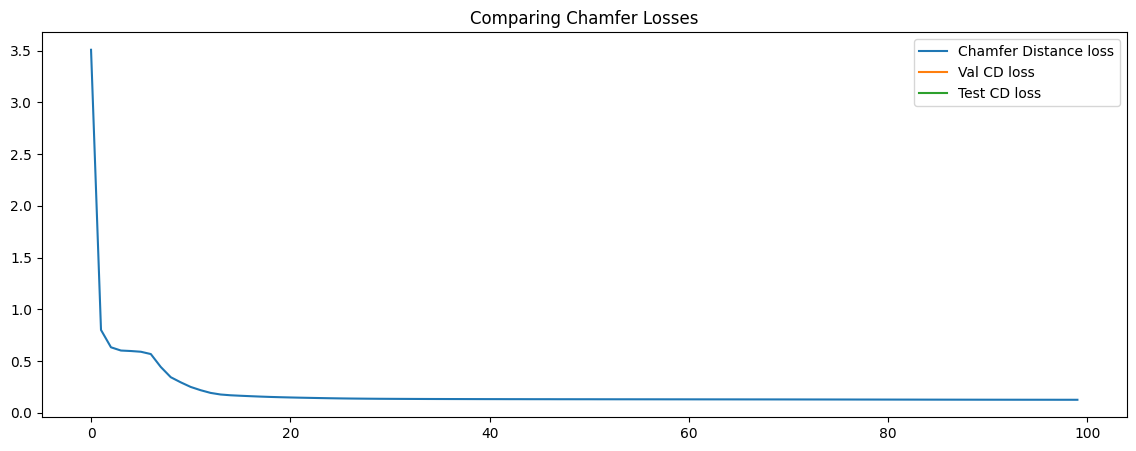

In [21]:
plt.figure(figsize=(14, 5))
plt.plot(cd_losses, label='Chamfer Distance loss')
plt.plot(val_cd_loss, label='Val CD loss')
plt.plot(test_cd_loss, label='Test CD loss')
plt.legend()
plt.title('Comparing Chamfer Losses')
plt.show()

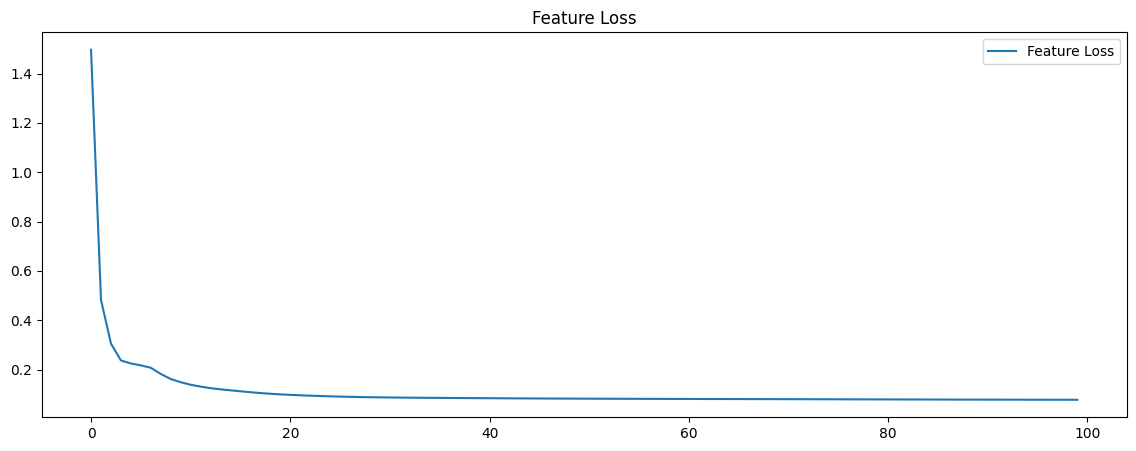

In [20]:

plt.figure(figsize=(14, 5))
plt.plot(feature_losses, label='Feature Loss')
plt.legend()
plt.title('Feature Loss')
plt.show()